# Benchmarking ros-orf functions

In ros-orf level 2, where I created a program to find putative ORFs, I just focused on writting functions that could acheive the objectives. In level 3, I wanted to re-think how the code is written and organized, with the goal of improving both usability and performance.

**This notebook focuses on assessing how those level 3 modifications impacted the performance of the functions.**

The assessment entails:
1. Creating sample FASTA files containing variable number and length of DNA sequences.
2. Benchmarking level 2 functions in terms of running time.
3. Testing running time of level 3 modified functions.
4. Comparing function performance

## 1. Creating sample FASTA files

I want sample FASTA files with varying number and length of random DNA sequences.

| Total bp in file | Number of sequences | Sequence length | File name |
| ---------------- | --------------- | ------------------- | --------- |
| 10 kb | 1 | 10 kb | rosorf_benchm_n1_l10.fasta |
| 100 kb | 1 | 100 kb | rosorf_benchm_n1_l100.fasta |
| 100 kb | 10 | 10 kb | rosorf_benchm_n10_l10.fasta |
| 1000 kb (1 Mb) | 1 | 1000 kb | rosorf_benchm_n1_l1000.fasta |
| 1000 kb (1 Mb) | 10 | 100 kb | rosorf_benchm_n10_l100.fasta |
| 1000 kb (1 Mb) | 100 | 10 kb | rosorf_benchm_n100_l10.fasta |
| 10000 kb (10 Mb) | 1 | 10000 kb | rosorf_benchm_n1_l10000.fasta |
| 10000 kb (10 Mb) | 10 | 1000 kb | rosorf_benchm_n10_l1000.fasta |
| 10000 kb (10 Mb) | 100 | 100 kb | rosorf_benchm_n100_l100.fasta |
| 10000 kb (10 Mb) | 1000 | 10 kb | rosorf_benchm_n1000_l10.fasta |


##### Steps to create sample FASTA files

**1. The modules:**

I created functions to generate random DNA sequences and save them in FASTA files. These functions could be imported as modules and used.

The functions, contained in file `mod_random_dna.py`, are the following:
- `random_dna_generator(n, length, gc, batch_id)`
    - Generates random DNA sequences following input parameters
    - Input:
        - `n` (int): Number of sequence to generate.
        - `length` (int): Lenght of each sequence (in bp).
        - `gc` (int): Sequence GC% (between 0 and 100).
        - `batch_id` (str): General identifier for sequences (e.g., experiment).
    - Output:
        - List of SeqRecord objects with random DNA sequences.
- `seqrecord_fasta_writer**(seqrecord_list, filename)`
    - Write a list of SeqRecord objects to a FASTA file.
- `seqrecord_fasta_printer**(seqrecord_list)`
    - Print SeqRecords from list to the console.


**2. Packaging the modules:**

To also facilitate use of the functions across projects and future applications, I wanted to store the modules in a package `random_seq`. I did so by creating the new directory (i.e., the package) and storing in it the module file `mod_random_dna.py` alongside a `__init__.py` file, then setting `$PYTHONPATH` to the package's parent directory. The `__init__.py` file contains the line to enable directly accessing the functions: `from .mod_random_dna import random_dna_generator, seqrecord_fasta_writer, seqrecord_fasta_printer`. This means that to import these functions all that is needed is e.g.: `from random_seq import random_dna_generator`.

Note: I haven't actually succeeded in doing what I wanted, exactly. At the moment the path to the packages has to be for every file.

In [45]:
# Set path to access packages
import sys
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')

**3. Using the modules to create FASTA files:**

I created a script to enable using generating random DNA FASTA through the bash command line.

However, I used the code block bellow to create the files:

In [3]:
import os
import sys
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from random_seq import random_dna_generator, seqrecord_fasta_writer

# Set (n, l). Max total bp = 10000 kb (10 Mb)
parameters = [
    (1, 10), (10, 10), (100, 10), (1000, 10),
    (1, 100), (10, 100), (100, 100), #(1000, 100),
    (1, 1000), (10, 1000), #(100, 1000), (1000, 1000),
    (1, 10000) #,(10, 10000), (100, 10000), (1000, 10000),
    ]

folder_name = 'sample-dna-fasta'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Created directory: {folder_name}')

for n, l in parameters:
    record = random_dna_generator(n, l*1000, gc=50, batch_id='rosorf')
    file_name = os.path.join(folder_name, f'rosorf_benchm_n{n}_l{l}.fasta')
    seqrecord_fasta_writer(record, file_name)
    print(f'Created file: {file_name}')


Created file: sample-dna-fasta\rosorf_benchm_n1_l10.fasta
Created file: sample-dna-fasta\rosorf_benchm_n10_l10.fasta
Created file: sample-dna-fasta\rosorf_benchm_n100_l10.fasta
Created file: sample-dna-fasta\rosorf_benchm_n1000_l10.fasta
Created file: sample-dna-fasta\rosorf_benchm_n1_l100.fasta
Created file: sample-dna-fasta\rosorf_benchm_n10_l100.fasta
Created file: sample-dna-fasta\rosorf_benchm_n100_l100.fasta
Created file: sample-dna-fasta\rosorf_benchm_n1_l1000.fasta
Created file: sample-dna-fasta\rosorf_benchm_n10_l1000.fasta
Created file: sample-dna-fasta\rosorf_benchm_n1_l10000.fasta


## 2. Benchmarking level 2 functions

**Method:**
I first needed a method to test function performance. I have previously tried using the timeit simulations, but found a big discrepency between actual running time and the simulation result when comparing different functions - i.e., using the same test files to both run and do timeit simulation on a pair of functions I wanted to compare, I found that the timeit simulation indicated faster performance for the function that actually ran the slowest. For this reason, I will stick with registering running time as the method to benchmark the level 2 functions.

I wrote a function to measure the running time of each of the functions and store the data in a dataframe.

To simplify the code and make it more usable, I first packaged the level 2 functions in `rosorf_level_2`, with the `__init__.py` file to access the functions. Then I could import the modules and perform the analysis.

In [ ]:
import os
import datetime
import sys
import pandas as pd
import re
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from rosorf_level_2 import fasta_dna_parser, orf_finder, orf_data_collector#, orf_dna_fasta_generator, orf_mrna_fasta_generator, orf_peptide_fasta_generator



def runtime_level_2(file_list):
    
    # Initiate lists to store data
    file_names = []
    n_orfs = []
    mod1 = []
    mod2 = []
    mod3 = []

    # Calculate running time for functions (fasta_dna_parser, orf_finder and orf_data_collector) and add data to lists
    for file in files:

        mod1_name = f'mod1_{file}'
        mod1_start_time = datetime.datetime.now()
        globals()[mod1_name] = fasta_dna_parser(f'rosorf_benchm_{file}.fasta')
        mod1_end_time = datetime.datetime.now()
        mod1_runtime = mod1_end_time - mod1_start_time
        #print(f'fasta_dna_parser(): {mod1_runtime}')

        mod2_name = f'mod2_{file}'
        mod2_start_time = datetime.datetime.now()
        globals()[mod2_name] = orf_finder(globals()[mod1_name])
        mod2_end_time = datetime.datetime.now()
        mod2_runtime = mod2_end_time - mod2_start_time
        #print(f'orf_finder(): {mod2_runtime}')

        mod3_name = f'mod3_{file}'
        mod3_start_time = datetime.datetime.now()
        globals()[mod3_name] = orf_data_collector(globals()[mod1_name], globals()[mod2_name])
        mod3_end_time = datetime.datetime.now()
        mod3_runtime = mod3_end_time - mod3_start_time
        #print(f'orf_data_collector(): {mod3_runtime}')

        #print(f'No. of putative ORFs: {len(globals()[mod2_name])}\n')

        file_names.append(file)
        n_orfs.append(len(globals()[mod2_name]))
        mod1.append(mod1_runtime.total_seconds())
        mod2.append(mod2_runtime.total_seconds())
        mod3.append(mod3_runtime.total_seconds())

        print(f'Done with {file}')
    
    
    # Create dataframe from lists
    df_runtime = pd.DataFrame({
        'File ID': file_names,
        'No. putative ORFs': n_orfs,
        'fasta_dna_parser': mod1,
        'orf_finder': mod2,
        'orf_data_collector': mod3
    })

    return df_runtime

def runtime_data_lvl2(df):

    # Initiate lists to add new data
    n_seq = []
    l_seq = []
    total_bp = []

    # Define regex to extract n and l parameters from file ID
    pattern = f'n(\d+)_l(\d+)' # (\d+) captures groups

    # Iterate through df to get new data
    for file_id in df['File ID']:
        match = re.search(pattern, file_id)
        if match:
            n_seq.append(int(match.group(1)))
            l_seq.append(int(match.group(2)))
            total_bp.append(int(match.group(1))*int(match.group(2)))
        else:
            print('something is wrong')

    # Add new data to df
    df['No. of sequences'] = n_seq
    df['Length of sequences'] = l_seq
    df['Total bp'] = total_bp

    return df

In [ ]:
import os
os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')

files = [
    'n1_l10', 'n10_l10', 'n100_l10', 'n1000_l10',
    'n1_l100', 'n10_l100', 'n100_l100',
    'n1_l1000', 'n10_l1000',
    'n1_l10000'
]

df_lvl2 = runtime_level_2(files)
df_lvl2 = runtime_data_lvl2(df_lvl2)
df_lvl2.to_csv('benchm_lvl2_runtime.csv', encoding='utf-8', index=False)

## 3. Testing level 3 improvements

I repeated the analysis of `fasta_dna_parser` and `orf_finder` now with both level 2 and 3 versions, which I packaged all in `rosorf_level_3`.

In [ ]:
import os
import datetime
import sys
import pandas as pd
import re
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from rosorf_level_3 import fasta_parser_lvl3, fasta_parser_lvl2, orf_finder_lvl2, orf_finder_lvl3_v1

def runtime_level_3(file_list):
    
    # Initiate lists to store data
    file_names = []
    n_orfs = []
    mod1 = []
    mod2 = []
    mod3 = []
    mod4 = []

    # Calculate running time for functions (fasta_dna_parser, orf_finder and orf_data_collector) and add data to lists
    for file in file_list:

        mod1_name = f'mod1_{file}'
        mod1_start_time = datetime.datetime.now()
        globals()[mod1_name] = fasta_parser_lvl3(f'rosorf_benchm_{file}.fasta')
        mod1_end_time = datetime.datetime.now()
        mod1_runtime = mod1_end_time - mod1_start_time
        #print(f'fasta_dna_parser(): {mod1_runtime}')

        mod2_name = f'mod2_{file}'
        mod2_start_time = datetime.datetime.now()
        globals()[mod2_name] = orf_finder_lvl3_v1(globals()[mod1_name])
        mod2_end_time = datetime.datetime.now()
        mod2_runtime = mod2_end_time - mod2_start_time
        #print(f'orf_finder(): {mod2_runtime}')

        mod3_name = f'mod3_{file}'
        mod3_start_time = datetime.datetime.now()
        globals()[mod3_name] = fasta_parser_lvl2(f'rosorf_benchm_{file}.fasta')
        mod3_end_time = datetime.datetime.now()
        mod3_runtime = mod3_end_time - mod3_start_time
        #print(f'fasta_dna_parser(): {mod1_runtime}')

        mod4_name = f'mod4_{file}'
        mod4_start_time = datetime.datetime.now()
        globals()[mod4_name] = orf_finder_lvl2(globals()[mod3_name])
        mod4_end_time = datetime.datetime.now()
        mod4_runtime = mod4_end_time - mod4_start_time
        #print(f'orf_finder(): {mod2_runtime}')

        #print(f'No. of putative ORFs: {len(globals()[mod2_name])}\n')

        file_names.append(file)
        n_orfs.append(len(globals()[mod2_name]))
        mod1.append(mod1_runtime.total_seconds())
        mod2.append(mod2_runtime.total_seconds())
        mod3.append(mod3_runtime.total_seconds())
        mod4.append(mod4_runtime.total_seconds())

        print(f'done with {file}')
    
    # Create dataframe from lists
    df_runtime = pd.DataFrame({
        'File ID': file_names,
        'No. putative ORFs': n_orfs,
        'fasta_dna_parser Level 3': mod1,
        'orf_finder Level 3': mod2,
        'fasta_dna_parser Level 2': mod3,
        'orf_finder Level 2': mod4,
    })

    return df_runtime

def runtime_data_lvl3(df):

    # Initiate lists to add new data
    n_seq = []
    l_seq = []
    total_bp = []

    # Define regex to extract n and l parameters from file ID
    pattern = f'n(\d+)_l(\d+)' # (\d+) captures groups

    # Iterate through df to get new data
    for file_id in df['File ID']:
        match = re.search(pattern, file_id)
        if match:
            n_seq.append(int(match.group(1)))
            l_seq.append(int(match.group(2)))
            total_bp.append(int(match.group(1))*int(match.group(2)))
        else:
            print('something is wrong')

    # Add new data to df
    df['No. of sequences'] = n_seq
    df['Length of sequences'] = l_seq
    df['Total bp'] = total_bp

    return df


In [ ]:
import os
import sys

sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')
files = [
    'n1_l10', 'n10_l10', 'n100_l10', 'n1000_l10',
    'n1_l100', 'n10_l100', 'n100_l100',
    'n1_l1000', 'n10_l1000',
    'n1_l10000'
]

df_lvl3 = runtime_level_3(files)
df_lvl3 = runtime_data_lvl3(df_lvl3)
df_lvl3.to_csv('benchm_lvl3_runtime.csv', encoding='utf-8', index=False)

### Adding extra datapoints

In [ ]:
import os
import sys
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from random_seq import random_dna_generator, seqrecord_fasta_writer

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/')

# Set (n, l)
parameters_extra = [
    (1, 1), (10, 1), (100, 1), (500, 1), (1000, 1), (2500, 1), (5000, 1), (7500, 1), (10000, 1),
    (1, 25), (1, 250), (1, 2500),
    (1, 50), (1, 500), (1, 5000),
    (1, 75), (1, 750), (1, 7500),
    (10, 25), (10, 250),
    (10, 50), (10, 500),
    (10, 75), (10, 750),
    (250, 10), (500, 10), (750, 10),
    (25, 100), (50, 100), (75, 100),
    (100, 25), (100, 50), (100, 75)
]

folder_name = 'sample-dna-fasta'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f'Created directory: {folder_name}')

for n, l in parameters_extra:
    record = random_dna_generator(n, l*1000, gc=50, batch_id='rosorf')
    file_name = os.path.join(folder_name, f'rosorf_benchm_n{n}_l{l}.fasta')
    seqrecord_fasta_writer(record, file_name)
    print(f'Created file: {file_name}')


In [ ]:
import os
import sys
import pandas as pd
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')
df_lvl3_og = pd.read_csv('benchm_lvl3_runtime.csv')

files_extra_len = [
    'n1_l1', 'n10_l1', 'n100_l1', 'n500_l1', 'n1000_l1', 'n2500_l1', 'n5000_l1', 'n7500_l1', 'n10000_l1',
    'n1_l25','n1_l250','n1_l2500',
    'n1_l50','n1_l500','n1_l5000',
    'n1_l75','n1_l750','n1_l7500',
    'n10_l25','n10_l250',
    'n10_l50','n10_l500',
    'n10_l75','n10_l750',
    'n250_l10', 'n500_l10', 'n750_l10',
    'n25_l100', 'n50_l100', 'n75_l100',
    'n100_l25', 'n100_l50', 'n100_l75'
]

df_lvl3_extra_len = runtime_level_3(files_extra_len)
df_lvl3_extra_len = runtime_data_lvl3(df_lvl3_extra_len)

df_lvl3_upd = pd.concat([df_lvl3_og, df_lvl3_extra_len])
df_lvl3_upd.to_csv('benchm_lvl3_upd_runtime.csv', encoding='utf-8', index=False)

## 4. Data analysis: comparing function performance

Finally, I analysed the gathered data. I did so, with newly created module to make a grid of heatmap plots `heatmap_grid` (in newly created package for plots `mypyplots`), where effect of number and length of sequences on running time can be visualized at once.

#### Benchmarking level 2 functions fasta_dna_parser, orf_finder and orf_data_collector:

Running time of these level 2 functions is affected by number of sequences and length of sequences in a similar way. When predicting performance of the function for a given FASTA file, one can consider the total bp in that file (Number * Length of sequences).

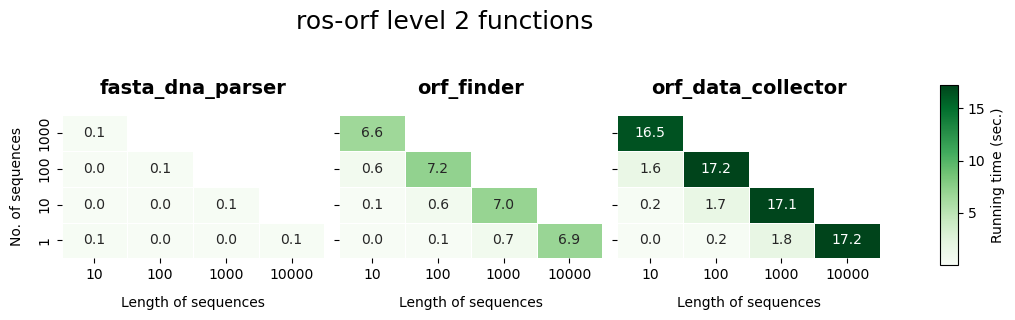

#### Comparing functions fasta_dna_parser and orf_finder across levels:
For fasta_dna_parser, level 2 and 3 functions perform equally well at the tested scale.

For orf_finder, unlike the level 2 function, the running time of the level 3 function is affected differently by the number of sequences and the length of sequences. While it might perform slightly better than the level 2 function when increasing the number of sequences, it handles 1 Mb sequences much worse.

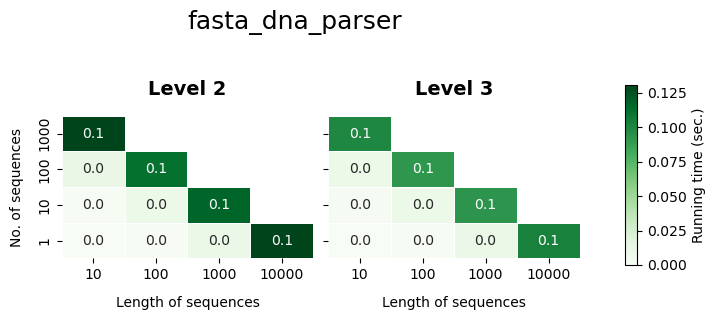
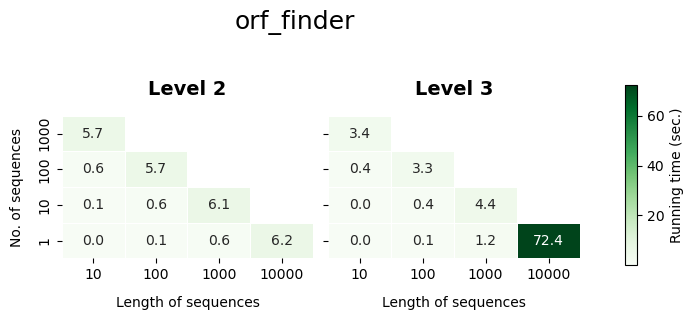


To further visualize the impact of length of sequences or number of sequences on running time of the orf_finder functions, I inspected it at a fixed number or length of sequences, respectively. Level 3 orf_finder dips in performance when processing DNA sequences longer than 1Mb (for example, a genome...), but is otherwise marginally better than level 2.

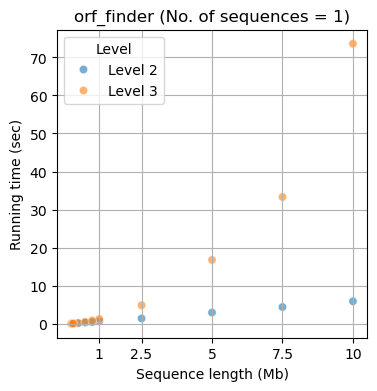
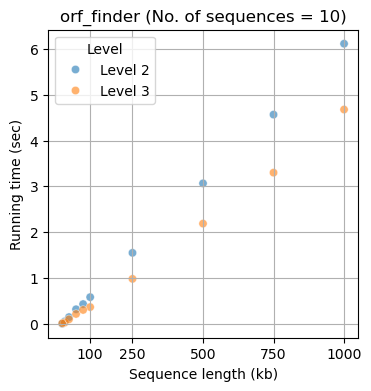
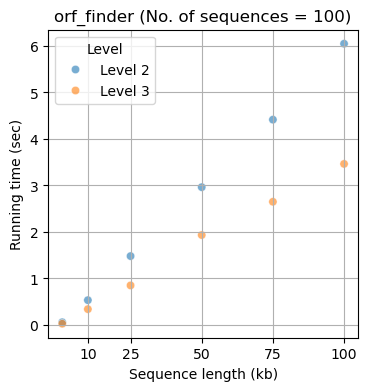

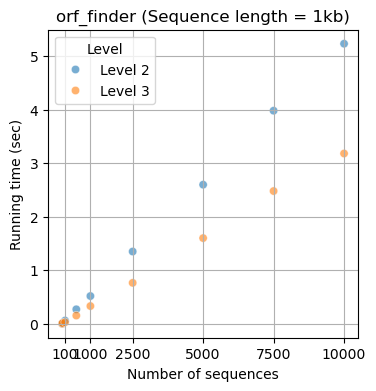
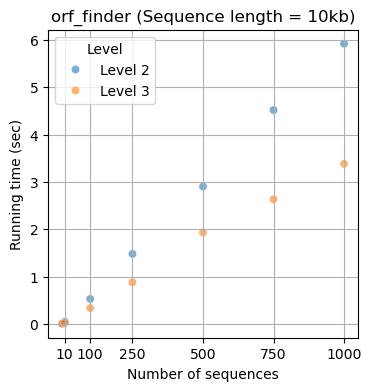
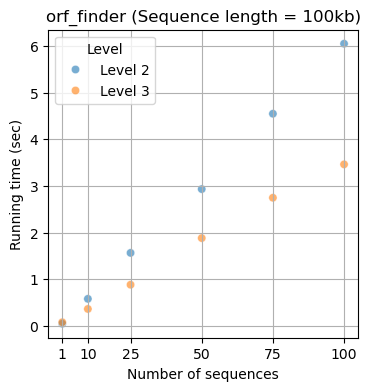

Note: To get a more complete picture of the trends, I increased the number datapoints.

Conclusion:

Level 2 orf_finder is the better option for a single DNA sequences (and a lot more so if sequences is >1Mb), while level 3 orf_finder is the better option for higher number of DNA input sequences. However, I don't think the level 3 orf_finder modifications constitute actual improvements, so I will drop them.

### Level 2 data

In [ ]:
import os
import pandas as pd
import sys
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from mypyplots import heatmap_grid

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')
df_lvl2 = pd.read_csv('benchm_lvl2_runtime.csv')

# Melt the DataFrame to have a long format for plotting
df_melt_lvl2 = pd.melt(df_lvl2, 
                    id_vars=['Total bp', 'Length of sequences', 'No. of sequences', 'No. putative ORFs'], 
                    value_vars=['fasta_dna_parser', 'orf_finder', 'orf_data_collector'],
                    var_name='Function', 
                    value_name='Running Time')


# Create the FacetGrid for Level 2 heatmaps with colorbar
heatmap_grid(
    data=df_melt_lvl2,
    xaxis='Length of sequences',
    yaxis='No. of sequences',
    heatval='Running Time',
    subpvar='Function',
    gridtitle='ros-orf level 2 functions',
    heatbartitle='Running time (sec.)'
)


### Level 3 data

In [ ]:

import os
import pandas as pd
import sys
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from mypyplots import heatmap_grid

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')
df_lvl3 = pd.read_csv('benchm_lvl3_runtime.csv')

# Prepare df for plot:
df_melt_lvl3 = pd.melt(df_lvl3, 
                    id_vars=['Total bp', 'Length of sequences', 'No. of sequences', 'No. putative ORFs'], 
                    value_vars=['fasta_dna_parser Level 2', 'orf_finder Level 2', 
                                'fasta_dna_parser Level 3', 'orf_finder Level 3'],
                    var_name='Function_Level', 
                    value_name='Running Time')

# Split 'Function_Level' into 'Function' and 'Level'
df_melt_lvl3[['Function', 'Level']] = df_melt_lvl3['Function_Level'].str.split(' ', n=1, expand=True)
df_melt_lvl3 = df_melt_lvl3.drop(columns=['Function_Level'])


heatmap_grid(
    data=df_melt_lvl3[df_melt_lvl3['Function']=='fasta_dna_parser'],
    xaxis='Length of sequences',
    yaxis='No. of sequences',
    heatval='Running Time',
    subpvar='Level',
    gridtitle='fasta_dna_parser',
    heatbartitle='Running time (sec.)'
)

heatmap_grid(
    data=df_melt_lvl3[df_melt_lvl3['Function']=='orf_finder'],
    xaxis='Length of sequences',
    yaxis='No. of sequences',
    heatval='Running Time',
    subpvar='Level',
    gridtitle='orf_finder',
    heatbartitle='Running time (sec.)'
)


In [ ]:
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('C:\\Users\\joanaq\\Documents\\learning-bioinformatics\\packages')
from mypyplots import heatmap_grid, linear_regression_plot, exponential_regression_fit, exponential_regression_plot

os.chdir('C:/Users/joanaq/Documents/learning-bioinformatics/projects/ros-orf/level-3/sample-dna-fasta')
df_lvl3_upd = pd.read_csv('benchm_lvl3_upd_runtime.csv')

# Prepare df for plot:
df_melt_lvl3_upd = pd.melt(df_lvl3_upd, 
                    id_vars=['Total bp', 'Length of sequences', 'No. of sequences', 'No. putative ORFs'], 
                    value_vars=['fasta_dna_parser Level 2', 'orf_finder Level 2', 
                                'fasta_dna_parser Level 3', 'orf_finder Level 3'],
                    var_name='Function_Level', 
                    value_name='Running Time')

# Split 'Function_Level' into 'Function' and 'Level'
df_melt_lvl3_upd[['Function', 'Level']] = df_melt_lvl3_upd['Function_Level'].str.split(' ', n=1, expand=True)
df_melt_lvl3_upd = df_melt_lvl3_upd.drop(columns=['Function_Level'])

# Filter and plot
df_melt_of_n1_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['No. of sequences']==1)]
df_melt_of_n10_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['No. of sequences']==10)]
df_melt_of_n100_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['No. of sequences']==100)]

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_n1_upd, x='Length of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Sequence length (Mb)')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (No. of sequences = 1)')
plt.xticks([1000, 2500, 5000, 7500, 10000], ['1', '2.5', '5', '7.5', '10'])
plt.grid()
plt.show()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_n10_upd, x='Length of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Sequence length (kb)')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (No. of sequences = 10)')
plt.xticks([100, 250, 500, 750, 1000])
plt.grid()
plt.show()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_n100_upd, x='Length of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Sequence length (kb)')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (No. of sequences = 100)')
plt.xticks([10, 25, 50, 75, 100])
plt.grid()
plt.show()


df_melt_of_l1_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['Length of sequences']==1)]
df_melt_of_l10_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['Length of sequences']==10)]
df_melt_of_l100_upd = df_melt_lvl3_upd[(df_melt_lvl3_upd['Function']=='orf_finder') & (df_melt_lvl3_upd['Length of sequences']==100)]


plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_l1_upd, x='No. of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Number of sequences')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (Sequence length = 1kb)')
plt.xticks([100, 1000, 2500, 5000, 7500, 10000])
plt.grid()
plt.show()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_l10_upd, x='No. of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Number of sequences')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (Sequence length = 10kb)')
plt.xticks([10, 100, 250, 500, 750, 1000])
plt.grid()
plt.show()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_melt_of_l100_upd, x='No. of sequences', y='Running Time', hue='Level', alpha=0.6)
plt.xlabel('Number of sequences')
plt.ylabel('Running time (sec)')
plt.title('orf_finder (Sequence length = 100kb)')
plt.xticks([1, 10, 25, 50, 75, 100])
plt.grid()
plt.show()


